<a href="https://colab.research.google.com/github/Sushmitha-Katti/EVA-4/blob/master/Session5/Code3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Code 3**
**Target**
1. Decreased the batch size from 128 to 64.

**Results**
1.  Parameters - 6280
2.  Best training accuracy- 99.22%
3.  Best test accuracy - 99.45%


**Analysis**
1. Model is still under-fitting
2. Test accuracy crosses 99.40%, but once. Need to vary learning rate for converging to a local minimum.












# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 99

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(                      
            
        nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),#Op_size = 26, RF = 3
        nn.ReLU(),
        nn.BatchNorm2d(8),

        nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),#Op_size = 24, RF = 5
        nn.ReLU(),
        nn.BatchNorm2d(8),

        nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),#Op_size = 22, RF = 5
        nn.ReLU(),
        nn.BatchNorm2d(8),

        nn.MaxPool2d(kernel_size=(2,2)), #Op_size = 11, RF = 6

        nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), #Op_size = 9, RF = 10   
        nn.ReLU(),
        nn.BatchNorm2d(12),

        nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), #Op_size = 7, RF = 14
        nn.ReLU(),
        nn.BatchNorm2d(16),

        nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),#Op_size = 5, RF = 18 
        nn.ReLU(),
        nn.BatchNorm2d(10),

        nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),#Op_size = 3, RF = 22 

        nn.AvgPool2d(kernel_size=3),#Op_size = 1, RF = 24
        ) 

    def forward(self, x):
        x = self.conv1(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4            [-1, 8, 24, 24]             576
              ReLU-5            [-1, 8, 24, 24]               0
       BatchNorm2d-6            [-1, 8, 24, 24]              16
            Conv2d-7            [-1, 8, 22, 22]             576
              ReLU-8            [-1, 8, 22, 22]               0
       BatchNorm2d-9            [-1, 8, 22, 22]              16
        MaxPool2d-10            [-1, 8, 11, 11]               0
           Conv2d-11             [-1, 12, 9, 9]             864
             ReLU-12             [-1, 12, 9, 9]               0
      BatchNorm2d-13             [-1, 12, 9, 9]              24
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 15
for epoch in range(1, EPOCHS+1):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.19640114903450012 Batch_id=937 Accuracy=95.01: 100%|██████████| 938/938 [00:18<00:00, 49.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0499, Accuracy: 9844/10000 (98.44%)

EPOCH: 2


Loss=0.07555632293224335 Batch_id=937 Accuracy=98.13: 100%|██████████| 938/938 [00:18<00:00, 50.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0360, Accuracy: 9890/10000 (98.90%)

EPOCH: 3


Loss=0.18858373165130615 Batch_id=937 Accuracy=98.42: 100%|██████████| 938/938 [00:18<00:00, 49.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9921/10000 (99.21%)

EPOCH: 4


Loss=0.0034900251775979996 Batch_id=937 Accuracy=98.63: 100%|██████████| 938/938 [00:19<00:00, 49.28it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9908/10000 (99.08%)

EPOCH: 5


Loss=0.07398080825805664 Batch_id=937 Accuracy=98.74: 100%|██████████| 938/938 [00:19<00:00, 49.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9909/10000 (99.09%)

EPOCH: 6


Loss=0.038573745638132095 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [00:19<00:00, 49.10it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9920/10000 (99.20%)

EPOCH: 7


Loss=0.1044900119304657 Batch_id=937 Accuracy=98.90: 100%|██████████| 938/938 [00:19<00:00, 49.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9928/10000 (99.28%)

EPOCH: 8


Loss=0.011771156452596188 Batch_id=937 Accuracy=99.01: 100%|██████████| 938/938 [00:19<00:00, 49.36it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9926/10000 (99.26%)

EPOCH: 9


Loss=0.0012363444548100233 Batch_id=937 Accuracy=98.99: 100%|██████████| 938/938 [00:18<00:00, 50.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9924/10000 (99.24%)

EPOCH: 10


Loss=0.0016236728988587856 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:19<00:00, 48.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9939/10000 (99.39%)

EPOCH: 11


Loss=0.029401002451777458 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:19<00:00, 49.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9933/10000 (99.33%)

EPOCH: 12


Loss=0.005006833933293819 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:18<00:00, 49.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9922/10000 (99.22%)

EPOCH: 13


Loss=0.0007376784342341125 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:19<00:00, 49.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9945/10000 (99.45%)

EPOCH: 14


Loss=0.0028294692747294903 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [00:19<00:00, 49.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9935/10000 (99.35%)

EPOCH: 15


Loss=0.03875298053026199 Batch_id=937 Accuracy=99.22: 100%|██████████| 938/938 [00:18<00:00, 49.40it/s]



Test set: Average loss: 0.0211, Accuracy: 9928/10000 (99.28%)



Text(0.5, 1.0, 'Test Accuracy')

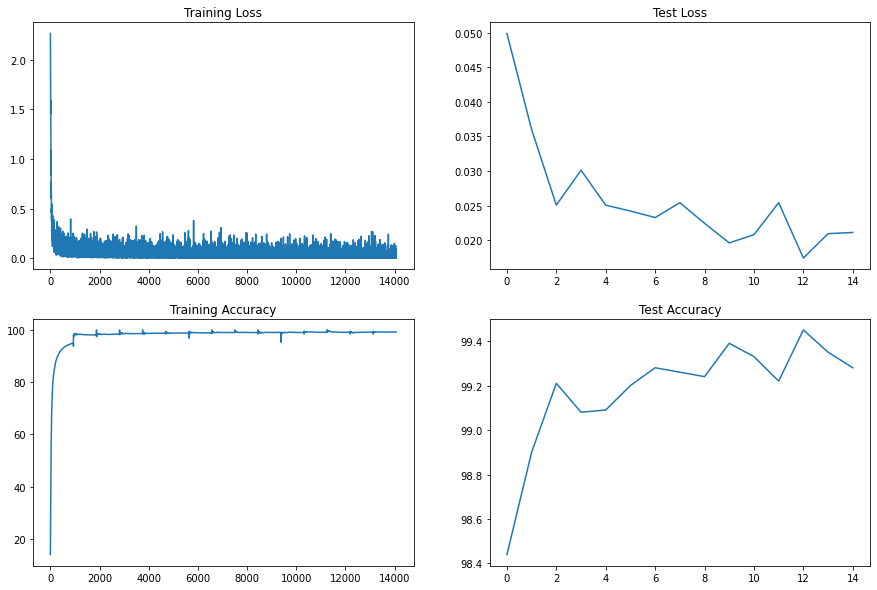

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")